# OpenQASM Parser Library

This notebook is intended to provide an insight into the _OpenQASM Parser Library_, able to parse a common quantum circuit description format used in the context of variational algorithms into the corresponding OpenQASM representation, utilizing parallel computing. 

## Prerequisites

To be able to use the library additional libraries must be installed. These include:
- OpenMP
- Thread Building Blocks (TBB)
- fmt

Further, we are using [*cmake*](https://cmake.org/download/) (already installed on many systems or part of the package manager) as our generator and GCC as our compiler. If not yet the default C/C++ compiler, install the *GNU Compiler Collection* (GCC) as your compiler to use the library. Some older versions of the GCC may must be upgraded to be used with the library. The reason for that is the necessity to use the execution policies first implemented in the C++17 standard. The GCC can be an globally existing binary, but other than that I would highly emphasize using a virtual environment, since we will install the library as an C++ Python binding and one probably does not want to install everything globally and eventually mess with the system on a global scale. An easy to use and project compatible virtual environment manager is [*Anaconda*](https://docs.anaconda.com/free/anaconda/install/index.html). Install Anaconda on your system and [create a virtual environment](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) with a fairly new Python version.

Assuming the used environment manager is Anaconda, installing the additional necessary libraries can be done like:
```
conda install -c conda-forge openmp
conda install -c conda-forge tbb
conda install -c conda-forge fmt
```

## Adding the Library to the Python Packages

After cloning the project in an appropriate location, we need to build and install the library. Therefore, the location of your Python *site-packages* folder must be known. The path can be found using `python -m site` command in a shell/terminal session. Be aware that the python binary pointed to is the correct one, meaning the one you want to be using. Verify by first executing `which python` and confirm that the path leads to your desired binary. In a virtual environment this should point to a binary in your virtual environment folder, e.g. `/Users/maxmustermann/opt/anaconda3/envs/environment_name/bin/python3.10` in Unix-like systems. The site packages should also be found in a similar location, e.g. `/Users/maxmustermann/opt/anaconda3/envs/environment_name/lib/python3.10/site-packages`.

After that, we are ready to build and install. In the library directory created when cloning the library from GitHub, we create a directory for our build. After changing into that directory we build the library and finally install it. For Unix-like systems the commands should be the following:
```
mkdir build && cd build
cmake .. -DCMAKE_C_COMPILER=/path_or_alias/to/your/gcc-binary -DCMAKE_CXX_COMPILER=/path_or_alias/to/your/g++-binary -DPYTHON_LIBRARY_DIR="<your_path_to_your_site-packages>" -DPYTHON_EXECUTABLE="<your_path_to_your_python_binary>"
cmake --build .
cmake --install .
```
(The compiler must only be provided if the GCC is not yet the default compiler. Quotation marks are necessary!)

The library should now be installed as a python package. You can confirm by changing into the python site-packages directory and reviewing the content. A shared *openqasmparser* library should now be visible. You could also fire up a python session and try to import the library 
```
python
> import openqasmparser as qprs
>
```
If no error message pops up you are ***ready to go!***

In [1]:
import openqasmparser as qprs

## OpenQASM

_Open Quantum Assembly Language_ (OpenQASM) is considered to be the de facto standard when it comes to communicating with a quantum computing device. It builds a bridge from describing the circuit on classical hardware to actually implementing it on quantum hardware. Such representation, residing in between the classical and quantum part of the workflow, are called _intermediate representations_. The sole purpose of these intermediate representations is to be able to easily construct quantum circuits and be able to implement those on various different quantum computing devices with (mostly) no additional cost for the user. 

Currently, two major OpenQASM versions are available, [version 2](https://arxiv.org/abs/1707.03429) and [3](https://arxiv.org/abs/2104.14722). Version 3 further extends the capabilities of the intermediate representation and provides the user with more advanced possibilities to construct circuits and instruct quantum devices. As they describe it: [In principle, any quantum computation could be described using OpenQASM 2, but there is a need to describe a broader set of circuits beyond the language of qubits and gates.][1] The library presented here is indifferent between the two versions since the more advanced instructions working with the circuit described/generated are not (yet) implemented, neither in the library implementation itself nor in the input representation. Nevertheless, both versions are supported, the only difference is in the headers specific to the specified version used. Both headers can be seen in the following:

[1]: https://arxiv.org/abs/2104.14722

In [2]:
header_v2 = qprs.parse_circuit("", version=2)
header_v3 = qprs.parse_circuit("", version=3)

print(header_v2)
print(header_v3)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
creg c[6];

OPENQASM 3.0;
include "stdgates.inc";
qubit[6] q;
bit[6] c;



## Input Representation

The goal of the library is to minimize the effort needed to instruct quantum computing devices. The instruction can happen directly, on quantum hardware level, or using the intermediate representations, e.g. OpenQASM instruction files. Instructing quantum devices manually is too tedious and time consuming for the upcoming larger scale quantum devices and poses a threat for a bottleneck in the quantum computing workflow. Intermediate representations can be constructed once and used on different devices without the need of knowing the exact hardware capabilities of the devices at hand. The library's input representation used could possibly be an intermediate representation by itself, but considering the broad usage and support of OpenQASM using OpenQASM as an intermediate representation simplifies and generalizes the usage on most devices. 

OpenQASM is a code-like language with which one could write his desired circuits by hand. But even these files will become of such large scale for problems suitable on future more capable devices that writing these by hand will also reach its feasible limits. Therefore, we propose a different representation, easy to generate and well suited for the usage in the variational quantum algorithms context. 

The Pauli operations form together with the identity a complete basis set, meaning we can construct any arbitrary operation using these four by suitable transformation. They also have an added advantage, since they are such basic operations nearly every quantum computing device has the hardware capabilities to perform these operations directly. The input file to generate can be a simple text file. The Pauli operations are represented by the capital letters *X, Y, Z* and the identity as the capital letter *I*. We now represent the ansatz, a (parameterized) circuit, as an unitary collection of *m* operators which is basically a product of *m* sequentially applied unitaries:

$$ \mathbb{U}(\boldsymbol{\theta}) = \mathbb{U}_m(\theta_m) \dots \mathbb{U}_2(\theta_2) \mathbb{U}_1(\theta_1)$$

Therfore, our input file consists of *m* lines, one for each operator unitary of the ansatz. Each of the unitaries is composed of multiple gates, parameterized and unparameterized. Looking at a single unitary acting on a system with *N* qubits in its exponentiated form

$$ \mathbb{U}_i(\theta_i) = \exp\{-i \theta_i \hat{a}_i^{\otimes N}\} $$
where 
$$ \hat{a}_i^{\otimes N} = \otimes_{l=1}^N \Theta_{i,l}\ :\ \Theta \in \{X,Y,Z,I\}$$
we find the Pauli and identity operations in \\(\hat{a}\\). This tensor product will build the foundation of our input representation, where the tensor product of Paulis and identity is written as a string \\(S_i\\). Consider the unitary \\(\exp{-i \theta \sigma_x \otimes \sigma_I \otimes \sigma_x}\\), the string representation as part of the input file to the library would simply be *XIX*. Another variable to set in the input file is the coefficient \\(c_i\\), seperated from the string by whitespace and in floating point accuracy, corresponding to the real-valued parameter \\(\theta_i\\). The last parameter of our input representation if not to be seen in the mathematical description of the operator. In order to group commuting operators together, reducing the computational effort when optimizing the parameters, we introduce an enumerating grouping index \\(p_i\\). The same index indicates commuting operators, while different grouping index parameters indicate non-commuting operators which must be optimized individually. Putting everything together we have our input representation to generate:

$$ A \equiv \{(S_i, c_i, p_i)\ :\ i \in \{1, \dots m\}\} $$

To get a better understanding let's look at an example. Consider an ansatz for \\(N=3\\) qubits and \\(m=2\\) independent operators as 

$$ \exp\{-i \cdot 1.0 \cdot \sigma_y \otimes \sigma_y \otimes \sigma_I\} \exp\{-i \cdot 1.5 \cdot \sigma_y \otimes \sigma_I \otimes \sigma_z\} $$

The corresponding input file to our library would look as follows:
> YYI 1.0 1
> 
> YIZ 1.5 2

Note how the grouping index enumerates, indicating independent operators. The same could be achieved by setting both grouping index parameters to 0, the algorithm then enumerates independent parameters by itself. The same ansatz assuming commuting operators which can be grouped would look similar
> YYI 1.0 1
>
> YIZ 1.5 1

but with the same grouping index to indicate the dependency.



## Using the Library

Now that we know how to construct an input file to be parsed into the OpenQASM representation, let's see how the library actually works. Therefore, take a look at the following examplaratory input ansatz. The ansatz is already in our library's desired input format and part of an actual ansatz used in the variational context on today's quantum computing devices. The ansatz can also be found in the additional data provided. 

In [3]:
import pandas as pd

ex_input = pd.read_csv("h2short.ansatz", sep=" ", header=None, names=["S_i", "c_i", "p_i"])
print(ex_input.to_string(index=False))


         S_i  c_i  p_i
IIIIIIIIIIXX  1.0    1
IIIIIIIIIIXY  1.0    2
IIIIIIIIIIXZ  1.0    3
IIIIIIIIIIYX  1.0    4
IIIIIIIIIIYY  1.0    5
IIIIIIIIIIYZ  1.0    6
IIIIIIIIIIZX  1.0    7
IIIIIIIIIIZY  1.0    8
IIIIIIIIIIZZ  1.0    9
IIIIIIIIIXIX  1.0   10


This is quite the compact format compared to other representations, as we will see soon. We can immediatly see two things when looking at the input file. First, the operators are all independent, which can be seen by the enumerating grouping index parameter \\(p_i\\). And second, this input file is actually unparameterized. All coefficients are set to 1, who's multiplication has no observable effect. 

To parse the input file in its OpenQASM representation, the library provides a function *parse_circuit*. Let's take a look at the function's help manual to see what we can do with it and how to call it.

In [4]:
help(qprs.parse_circuit)

Help on built-in function parse_circuit in module openqasmparser:

parse_circuit(...) method of builtins.PyCapsule instance
    parse_circuit(input_fn: str, *, version: int = 3, use_omp: bool = False, parameterize: bool = True, output_fn: Optional[str] = None, multiplier: Optional[float] = None) -> str
    
    Parse an ansatz into the corresponding OpenQASM representation, parallel execution enabled.
    @param input_fn: Path to the input file to parse.
    @param version: OpenQASM version to use, default 2.
    @param use_omp: Use OpenMP parallelism, default execution policy parallelism.
    @param parameterize: Set true to use indication for grouping commuting operators.
    @param output_fn: Path to (non-)existing file to store the OpenQASMrepresentation file. (optional)
    @param multiplier: Floating value to be multiplied to each operator. (optional)



We can specify five different variables. The only variable that must be set is the path to the input file. This variable is positional, meaning we need to specify this variable first when calling the function. All other variables are key-word only. In order to specify them you have to set the variable at call in the standard pythonic way, e.g. *use_omp=True*.

- *version*
  The version can be set to be OpenQASM v2 or v3. The only real difference is the header specific to that version in the output OpenQASM file. If not provided or set to a value other than 2 or 3, the default version used is version 3. To use parameterization version 3 is necessary.

- *use_omp*
  If parallelization is supported by your system, it is enabled by default. One can, for scientific/benchmarking purposes for example, decide which parallelization framework to use. If set to *True* OpenMP is the underlying parallelization framework, otherwise and by default the C++17 execution policies are used. These have the added advantage of automatic compiler optimization, leaving less room for unnecassary occupancy of resources or errors in general. If one wishes, he can tailor the OpenMP implementation in the C++ library source code to his specific needs.

- *parameterize*
  To indicate commuting operators we use the grouping index. This index is not visible in the OpenQASM representation directly, but indicates the usage of the same parameter for the rotation in z-basis. If one does not want to parameterize anyways, disabling the parameterization can be controlled using this variable.

- *output_fn*
  If specified, the OpenQASM representation is written to the file in that location. This value is optional. Nevertheless, the output of the function is still accessible in the current session, e.g. stored in a variable bound to that call.

- *multiplier*
  Value to be multiplied to each operator. If not set specifically, the circuit implementation uses a multiplier of \\(2\\). By changing this variable one can change the magnitude of the parameterization.

Now, calling the function and displaying the output looks like this:

In [5]:
# You can try out different additional parameters
# We parse the h2short.ansatz ansatz and store it in our calling directory of the notebook
circ1 = qprs.parse_circuit("h2short.ansatz", version=3, output_fn="./h2short.qasm", parameterize=True)
print(circ1)

OPENQASM 3.0;
include "stdgates.inc";
qubit[12] q;
bit[12] c;
input float param1;
input float param2;
input float param3;
input float param4;
input float param5;
input float param6;
input float param7;
input float param8;
input float param9;
input float param10;

// New operator from line 1
ry(pi/2) q[11];
ry(pi/2) q[10];
cx q[10], q[11];
rz(2*1*param1) q[11];
cx q[10], q[11];
ry(-pi/2) q[10];
ry(-pi/2) q[11];

// New operator from line 2
rx(-pi/2) q[11];
ry(pi/2) q[10];
cx q[10], q[11];
rz(2*1*param2) q[11];
cx q[10], q[11];
ry(-pi/2) q[10];
rx(pi/2) q[11];

// New operator from line 3
ry(pi/2) q[10];
cx q[10], q[11];
rz(2*1*param3) q[11];
cx q[10], q[11];
ry(-pi/2) q[10];

// New operator from line 4
ry(pi/2) q[11];
rx(-pi/2) q[10];
cx q[10], q[11];
rz(2*1*param4) q[11];
cx q[10], q[11];
rx(pi/2) q[10];
ry(-pi/2) q[11];

// New operator from line 5
rx(-pi/2) q[11];
rx(-pi/2) q[10];
cx q[10], q[11];
rz(2*1*param5) q[11];
cx q[10], q[11];
rx(pi/2) q[10];
rx(pi/2) q[11];

// New operato

A lot of lines of code-like OpenQASM, considering the input file consisted of only ten operators working on twelve qubits. Imagine the OpenQASM files of ansätze consisting of thousands of operators. You can try yourself setting other function call parameters.

Some remarks regarding the output. One can see the parameter initialization in the first lines after the header. The numbering actually corresponds to the grouping index. Trying to run this OpenQASM file on a simulator for example would result in an error. To do so, we first have to bind the parameters to the specific \\(\theta\\) values. Commuting operators use the same parameter and reduces the computational effort when optimizing since lesser parameters need to be optimized. Other than that, we can also see two numbers being multiplied before that. The second number is the coefficient of the input file. The other number can be set using the multiplier and if not set explicitly is \\(2.0\\). We explain that in the following, as well as why there are so many rotations.

But first, let's look at an actual circuit `test.ansatz`. We can use qiskits functionality to load circuits from OpenQASM files or strings (Additional qiskit modules may be required). I am using the `qasm3` module for v3 and the [`qiskit_qasm2` library](https://pypi.org/project/qiskit-qasm2/) for v2 and their respective `load` (for files) and `loads` (for strings) functionality. Note: To use visualization and/or jupyter notebooks the [visualization extra requirements](https://qiskit.org/documentation/stable/0.24/install.html) are recommended.

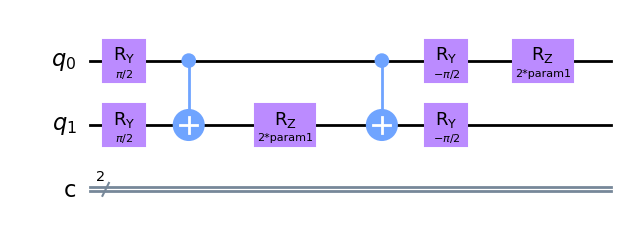

In [6]:
from qiskit import qasm3, BasicAer, transpile
import qiskit_qasm2

ansatz = qprs.parse_circuit("test.ansatz", parameterize=True, version=3)
qc = qasm3.loads(ansatz)
qc.draw('mpl')

In [7]:
backend = BasicAer.get_backend('qasm_simulator')

# Since there are no measurements, let's add them
qc.measure_all(add_bits=False)

# Bind the parameters by using an iterable (dict, list...)
pqc = qc.assign_parameters([1.57])

# Transpile circuit to fit used backend
tqc = transpile(pqc, backend)

# Run circuit and get measurement
counts = backend.run(tqc).result().get_counts()

print(counts)

{'11': 1024}


We can see that we obtain the state \\(\ket{11}\\) in all runs. In the next chapter we see the mathematical desciption of the operator's circuit implementation and one can calculate the result on paper. When using \\(\theta = \frac{\pi}{2}\\) the amplitude of the state \\(\ket{11}\\) corresponds to \\(1\\) and therefore the probability to obtain this state is \\(|1|^2 = 1\\).

This way we can use the library in a qiskit workflow for example to simplify the circuit generation. We used two commuting operators, sharing the same parameter. Further, we set the parameter to \\(\frac{\pi}{2}\\). You can try yourself changing the parameter(s) and/or ansatz. For example, what happens changing the parameter to \\(\pi\\), using non-commuting operators and specifying two parameters, ...

## Circuit Implementation

Imagine the simple input *ZZ*, who's exponentiation is given by \\(\exp\{-i \theta \sigma_z \otimes \sigma_z\}\\). To implement this operator in a circuit we can use *CNOT* and the rotation gate along the z-axis, simply sandwiching the rotation between *CNOT* gates. It is best understood when looking at the matrix form of the gates and operator:

$$ \exp{-i\theta \sigma_z \otimes \sigma_z} = \cos\left(\theta\right) \cdot I - i \sin\left(\theta\right) \sigma_z \otimes \sigma_z = 
\begin{pmatrix}
e^{-i\theta} & 0 & 0 & 0 \\
0 & e^{i\theta} & 0 & 0 \\
0 & 0 & e^{i\theta} & 0 \\
0 & 0 & 0 & e^{-i\theta} 
\end{pmatrix} $$

which is the matrix form of the operator, obtained by using Euler's formula, we are trying to implement in a circuit. Now, looking at the sandwiched rotation we obtain the same operator

$$ \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 
\end{pmatrix}
\begin{pmatrix}
e^{-i\theta} & 0 & 0 & 0 \\
0 & e^{i\theta} & 0 & 0 \\
0 & 0 & e^{-i\theta} & 0 \\
0 & 0 & 0 & e^{i\theta} 
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 
\end{pmatrix} = 
\begin{pmatrix}
e^{-i\theta} & 0 & 0 & 0 \\
0 & e^{i\theta} & 0 & 0 \\
0 & 0 & e^{i\theta} & 0 \\
0 & 0 & 0 & e^{-i\theta} 
\end{pmatrix}
$$

This is the most basic example, since we are only working in our computational basis, the z-axis. If other Pauli operations are present in the operator we need to rotate beforehand to actually perform the operator in the right computational basis. For example imagine another simple operator *XX*, doing the same comparison as before, we want to obtain following operator in matrix form

$$e^{-i\theta \sigma_x \otimes \sigma_x} = 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & -i \sin(\theta) \\
0 & \cos(\theta) & -i \sin(\theta) & 0 \\
0 & -i \sin(\theta) & \cos(\theta) & 0 \\
-i \sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix} \\
$$

and therefore we use parameterized rotation along the y-axis by \\(\frac{\pi}{2}\\) counterclockwise before and clockwise after the parameterized rotation in z-basis sandwiched by *CNOT* gates, given by the matrices

$$R_Y(\frac{\pi}{2}) \otimes R_Y(\frac{\pi}{2}) = 
\begin{pmatrix}
\frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} \\
\frac{1}{2} & \frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} \\
\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} & -\frac{1}{2} \\
\frac{1}{2} & \frac{1}{2} & \frac{1}{2} & \frac{1}{2} 
\end{pmatrix} \\ \quad ; \quad
R_Y(-\frac{\pi}{2}) \otimes R_Y(-\frac{\pi}{2}) = 
\begin{pmatrix}
\frac{1}{2} & \frac{1}{2} & \frac{1}{2} & \frac{1}{2} \\
-\frac{1}{2} & \frac{1}{2} & -\frac{1}{2} & \frac{1}{2} \\
-\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} & \frac{1}{2} \\
\frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} 
\end{pmatrix}
$$

We use the matrix result for the sandwiched rotation along the z-axis between *CNOT* gates to obtain

$$
\begin{pmatrix}
\frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} \\
\frac{1}{2} & \frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} \\
\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} & -\frac{1}{2} \\
\frac{1}{2} & \frac{1}{2} & \frac{1}{2} & \frac{1}{2} 
\end{pmatrix} 
\begin{pmatrix}
e^{-i\theta} & 0 & 0 & 0 \\
0 & e^{i\theta} & 0 & 0 \\
0 & 0 & e^{i\theta} & 0 \\
0 & 0 & 0 & e^{-i\theta} 
\end{pmatrix}
\begin{pmatrix}
\frac{1}{2} & \frac{1}{2} & \frac{1}{2} & \frac{1}{2} \\
-\frac{1}{2} & \frac{1}{2} & -\frac{1}{2} & \frac{1}{2} \\
-\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} & \frac{1}{2} \\
\frac{1}{2} & -\frac{1}{2} & -\frac{1}{2} & \frac{1}{2} 
\end{pmatrix} \\
= 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & -i \sin(\theta) \\
0 & \cos(\theta) & -i \sin(\theta) & 0 \\
0 & -i \sin(\theta) & \cos(\theta) & 0 \\
-i \sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix} \\
$$

and we can see that indeed the operator is the same. This actually means, that the universal rotation gate or the rotation gates along the axis and the *CNOT* present in the hardware implementation of the quantum device used are sufficient. State of the art quantum computers may even optimize the circuit to their specific hardware capabilities, but this form is the most general and applicable using the fewest and most basic gates.

For the Pauli-Y operation we perform the rotation along the x-axis clockwise before and counterclockwise afterward. Feel free to calculate the *YY* operator on your own to see that the result is indeed the same. 

This way, we have shown that all arbitrary combinations of Pauli operations in an operator can be implemented in a quantum circuit using rotation and *CNOT* gates, just like the library does.

Furthermore, looking at the parameterized rotation along the z-axis we see that the rotation is actually parameterized by \\(2\theta\\). This is the reason for the multiplier to be set to \\(2.0\\) by default. Other values are also possible and can be set by the multiplier parameter in the library function. One has to be aware of what he is actually trying to achieve by doing so.

## VQE

As another example we will perform a Variational Quantum Eigensolver (VQE) optimization. Goal of the VQE is to find the ground state energy of the system, which corresponds to the lowest energy eigenvalue, by optimizing the parameters of a given ansatz. 

Consider the Hamiltonian of the mean-field model: 
$$
H = -\frac{J}{L} \sum_{\langle i, j \rangle}^{L} \boldsymbol{\sigma_i} \cdot \boldsymbol{\sigma_j} - g \sum_{i=1}^{L} \sigma_i^z 
$$

Set \\(g=0\\) and rewrite:
$$
LH = -J \sum_{\langle i, j \rangle}^{L} \boldsymbol{\sigma_i} \cdot \boldsymbol{\sigma_j}
$$

In the antiferromagnetic case (\\(J=-1\\)) for a 2-qubit system (\\(L=2\\)) the Hamiltonian is given as:
$$
H = \sigma^x_1 \sigma^x_2 + \sigma^y_1 \sigma^y_2 + \sigma^z_1 \sigma^z_2
$$

In that case we can compute the ground state directly and use the numerical solution to verify the results of the VQE. To do so, we need to compute the eigenvalues.

In [8]:
import numpy as np


class ExactHamiltonian:
    """
    Class of Hamiltonian properties calculated numerically using exact diagonalization.

    Exact Hamiltonian class, providing access to the Hamiltonian's matrix representation,
    eigenvectors and -values, lowest eigenvalue (ground state energy), and the ground state vector.

    :ivar hamiltonian: Hamiltonian in Pauli basis representation.
    :ivar hamiltonian_matrix: Pauli basis hamiltonian in matrix representation.
    :ivar eigenvalues: Eigenvalues of the hamiltonian.
    :ivar eigenvectors: Eigenvectors of the hamiltonian.
    :ivar ground_energy: Ground state energy corresponding to the lowest eigenvalue.
    :ivar ground_statevector: Eigenvector corresponding to ground state energy (lowest eigenvalue).
    """

    def __init__(self, hamiltonian_fn: str):
        hamiltonian = []
        with open(hamiltonian_fn, "r") as input_hamiltonian:
            while True:
                line = input_hamiltonian.readline()
                if not line:
                    break
                values = line.split()
                hamiltonian.append((values[0], float(values[1]), float(values[2])))
        self.hamiltonian = hamiltonian
        self.hamiltonian_matrix = self.__matrix_repr()
        self.eigenvalues, self.eigenvectors = self.__eigen_vals_vecs()
        self.ground_energy = np.min(self.eigenvalues)
        self.ground_statevector = self.eigenvectors[:, np.argmin(self.eigenvalues)]

    def __str__(self) -> str:
        """
        Returns the hamiltonian in Pauli basis representation when class member is printed to console.

        :return str: Hamiltonian in Pauli basis representation.
        """
        h_string = ""
        for line in self.hamiltonian:
            h_string += f"{line[0]} {line[1]} {line[2]}\n"
        return h_string

    def __matrix_repr(self) -> np.ndarray:
        """
        Convert the input representation of the Hamiltonian into the matrix form using the Kronecker product.

        :return np.ndarray: Matrix form of the given Hamiltonian.
        """
        paulis = {
            "X": np.array([[0, 1], [1, 0]]),
            "Y": np.array([[0, -1j], [1j, 0]]),
            "Z": np.array([[1, 0], [0, -1]]),
            "I": np.array([[1, 0], [0, 1]]),
        }

        hamiltonian_matrix = np.zeros(
            (2 ** len(self.hamiltonian[0][0]), 2 ** len(self.hamiltonian[0][0])),
            dtype=complex,
        )
        for values in self.hamiltonian:
            coef = complex(values[1], values[2])
            matrix = paulis[values[0][0]]
            for i in range(1, len(values[0])):
                matrix = np.kron(matrix, paulis[values[0][i]])
            matrix * coef
            hamiltonian_matrix += matrix

        return hamiltonian_matrix

    def __eigen_vals_vecs(self) -> tuple:
        """
        Compute the eigenvalues and eigenvectors of the Hamiltonian's matrix form

        :return tuple(np.ndarray, np.ndarray): Eigenvalues as list, eigenvectors as list of list.
        """
        eigenvalues, eigenvectors = np.linalg.eigh(self.hamiltonian_matrix)
        return eigenvalues, eigenvectors


# Compute the ground state energy for the antiferromagnetic 2-qubit Hamiltonian
h_af = ExactHamiltonian("anti-ferromagnetic-2q.h")

print(f"Ground state energy of the antiferromagnetic 2-qubit Hamiltonian: {h_af.ground_energy}")

Ground state energy of the antiferromagnetic 2-qubit Hamiltonian: -3.0


So we know that the ground state energy of the Hamiltonian corresponds to \\(-3\\). 

Now, we want to calculate the (hopefully) same result using the VQE. The VQE consists of two parts, the classical and quantum part. On the quantum part, we compute the state after the ansatz transformation. Usually, on a real world quantum computing device, the obtained results of a computation are classical bitstrings corresponding to the collapsed state of the quantum computer. To obtain the actual final state, to some degree of error, one needs to perform and measure multiple times to approximate the amplitudes, trying to reconstruct the actual statevector. For the sake of simplicity, we use the simulator provided by Qisktit, which performs error free computation and allowing us to directly use the obtained statevector. 

This statevector is used on the classical part of the VQE. There we are trying to minimize the expectation value of the Hamiltonian, an upper bound to the true ground state energy. The expectation value is calculated as
$$ 
\frac{\langle \Psi(\theta) | H | \Psi(\theta)\rangle}{\langle \Psi(\theta) | \Psi(\theta) \rangle}
$$
The normalization can be neglected in our example, since the statevectors obtained using Qiskit's simulator are already in normalized form. This function is the cost function, the function to optimize (e.g. minimize), to our optimization. The parameters span a possible energy landscape, the minimization method used changes the parameters accordingly, some gradient-based others not. 

So let's construct the function calcualting the expectation value, or cost function, and the VQE...

In [9]:
import qiskit

from typing import Union
from qiskit import QuantumCircuit, qasm3
from scipy.optimize import minimize, OptimizeResult


class VQE(ExactHamiltonian):
    """
    Class implementing the VQE to solve ground state energy calculation.

    Quasi-Dynamical Evolution (VQE) uses multiple runs of parameter optimizations to calculate
    the ground state energy of a Hamiltonian. This class inherits the exact diagonalization results to be able to
    verify the results.

    :ivar ansatz_fn: Complete path pointing to the ansatz used to calculate ground state energy.
    :ivar qasm_ansatz: Ansatz in OpenQASM representation.
    :ivar circuit: Ansatz as quantum circuit object in Qiskit.
    :ivar _runs: Distinct runs of the circuit on a QC emulator.
    """

    def __init__(self, hamiltonian_fn: str, ansatz_fn: str):
        ExactHamiltonian.__init__(self, hamiltonian_fn=hamiltonian_fn)
        self.ansatz_fn = ansatz_fn
        self.qasm_ansatz = qprs.parse_circuit(self.ansatz_fn, parameterize=True, version=3)
        self.circuit = qasm3.loads(self.qasm_ansatz)
        self.runs = 1024

    def run_circuit(
        self,
        parameters: Union[list[float], dict[str, float], np.ndarray],
        initial_state: QuantumCircuit = None,
    ) -> np.ndarray:
        """
        Run a single circuit transformation of the given ansatz.

        :param parameters: Parameters to parameterize the ansatz circuit.
        :param initial_state: Initial state to prepare the circuit in.
        :return np.ndarray: Statevector after transformation.
        """
        circuit = (
            initial_state.compose(self.circuit) if initial_state is not None else self.circuit
        )
        backend = qiskit.BasicAer.get_backend(
            "statevector_simulator"
        ) 
            
        circuit = circuit.assign_parameters(parameters)
        transpiled_circ = qiskit.transpile(circuit, backend)
        statevector = (
            backend.run(transpiled_circ, shots=self.runs)
            .result()
            .get_statevector(transpiled_circ, decimals=16)
        )

        return statevector

    def expectation_value(
        self,
        parameters: Union[list[float], dict[str, float], np.ndarray, None] = None,
        initial_state: QuantumCircuit = None,
    ) -> np.ndarray:
        """
        Calculate the expectation value of the observable (Hamiltonian) and the given circuit ansatz.
        The statevector is already normalized.

        :param parameters: Parameters to parameterize ansatz circuit when run on QC.
        :param initial_state: Prepare circuit in initial state using different circuit (e.g. previous VQE result).
        :return: Expectation value of the Hamiltonian. Array collapses to scalar.
        """
        if type(parameters) == np.ndarray:
            parameters = parameters.tolist()
        statevector: np.ndarray = self.run_circuit(
            parameters=parameters, initial_state=initial_state
        )
        return np.dot(statevector.conj(), np.dot(self.hamiltonian_matrix, statevector))

    def vqe(
        self,
        method: str = "cobyla",
        initial_state: QuantumCircuit = None,
    ) -> OptimizeResult:
        """
        Perform a complete VQE parameter optimization loop, optimizing the parameters of the given
        ansatz to minimize the expectation value of the observable (Hamiltonian).

        :param method: Optimization method to use
        :param initial_state: Prepare circuit in initial state using different circuit (e.g. previous VQE result)
        :return: Callback dictionary holding the final statevector, expectation value, number of iterations,
                 and expectation value
        """
        x0 = np.asarray(
            [0.0]
        ) 

        res = minimize(
            self.expectation_value,
            x0,
            args=initial_state,
            method=method,
        )

        return res


# Initialize VQE object
vqe = VQE("anti-ferromagnetic-2q.h", "anti-ferromagnetic-2q.ansatz")

Now we have got everything set up. Lastly, we need an ansatz. We take a simple ansatz with only a single operator and parameter to optimize. The ansatz acts on the initial state \\(\ket{10}\\). Our implementation above allows us to specify a circuit transforming \\(\ket{00}\\) into the desired state to be prepended. To verify, that the ansatz is indeed capable of finding the ground state energy, we plot the energy landscape. 

/Users/cedricgaberle/opt/anaconda3/envs/quantum_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


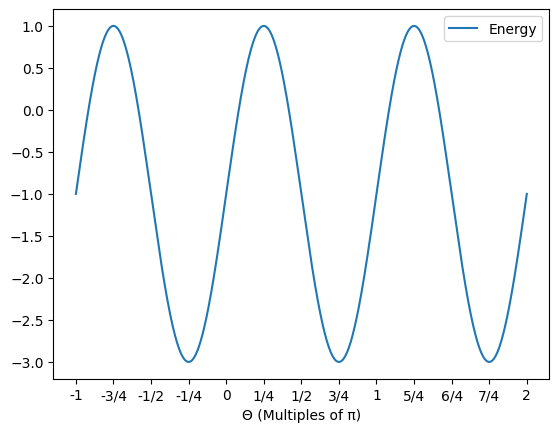

In [10]:
import matplotlib.pyplot as plt


def plot_energy_landscape(vqe: VQE, initial_state: QuantumCircuit = None) -> None:
    """
    Plot the energy landscape of the ansatz for different parameter values in the range of 0 to 2*pi.
    """
    x_axis = np.linspace(-np.pi, 2 * np.pi, 1000)
    energies = [vqe.expectation_value([p], initial_state) for p in x_axis]
    plt.plot(x_axis, energies, label="Energy")
    plt.legend()
    plt.xticks(
        np.arange(-np.pi, 2 * np.pi + 0.1, np.pi / 4),
        [
            "-1",
            "-3/4",
            "-1/2",
            "-1/4",
            "0",
            "1/4",
            "1/2",
            "3/4",
            "1",
            "5/4",
            "6/4",
            "7/4",
            "2",
        ],
    )
    plt.xlabel("Θ (Multiples of π)")
    plt.show()

qc_initial = QuantumCircuit(2, 2)
qc_initial.x(0)
plot_energy_landscape(vqe, qc_initial)

Lastly, let's run the VQE optimization loop. You can try out different [optimization methods](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

In [11]:
print(vqe.vqe(initial_state=qc_initial))

/Users/cedricgaberle/opt/anaconda3/envs/quantum_env/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.999999986503786
       x: [-7.855e-01]
    nfev: 23
   maxcv: 0.0


***Success!***

We found the ground state energy (to some degree of error due to machine precision), and the parameter to obtain the state, \\(-\frac{\pi}{4}\\).

Important to note, we did not need to construct a new *QuantumCircuit* each time we got new parameters, but rather constructed the circuit corresponding to the ansatz just once and assigned different parameters each time before running it on the quantum machine. As one can imagine, this reduces the computational effort drastically, compared to generating a new circuit with different parameters each and every time we change them during the optimization loop.

In [18]:
class VQEEmulator:
    """
    Class implementing the (Quasi-Dynamical Evolution) VQE to solve ground state energy calculation.

    Quasi-Dynamical Evolution VQE uses multiple runs of VQE parameter optimizations to calculate
    the ground state energy of a Hamiltonian. Previous optimizations are used as prepended circuit
    to the current VQE run. This class inherits the exact diagonalization results to be able to
    verify the results.

    :ivar hamiltonian_fn: Complete path pointing to the Hamiltonian under study.
    :ivar ansatz_fn: Complete path pointing to the ansatz used to calculate ground state energy.
    :ivar qasm_ansatz: Ansatz in OpenQASM representation.
    :ivar circuit: Ansatz as quantum circuit object in Qiskit.
    :ivar _num_qubits: Number of involved qubits in the ansatz.
    :ivar _num_params: Number of individual parameters in the ansatz.
    :ivar _runs: Distinct runs of the circuit on a QC emulator.
    """

    def __init__(self, hamiltonian_fn: str, ansatz_fn: str, backend):
        self.hamiltonian_fn = hamiltonian_fn
        self.ansatz_fn = ansatz_fn
        self.backend = backend

        self.qasm_ansatz = qprs.parse_circuit(
            self.ansatz_fn, parameterize=True, version=3
        )
        self.h_terms = self.__get_hamiltonian_terms()
        self.circuit = qasm3.loads(self.qasm_ansatz)
        self.initial_state = None
        self.initial_parameters = None
        self._num_qubits = self.__get_num_qubits()
        self._num_params = self.__get_num_params()

        self._runs = 1024

    def __get_num_qubits(self) -> int:
        """
        Get number of qubits used in the given ansatz.
        """
        with open(self.ansatz_fn, "r") as ansatz:
            line = ansatz.readline()
            return len(line.split()[0])

    def __get_num_params(self) -> int:
        """
        Get number of individual parameters in ansatz.
        """
        params = set([])
        with open(self.ansatz_fn, "r") as ansatz:
            while True:
                line = ansatz.readline()
                if not line:
                    break
                params.add(line.split()[2])

        return len(params)

    def __get_hamiltonian_terms(self) -> list[tuple[str, complex]]:
        """
        Split Hamiltonian single strings representation into its respective terms.

        A single term of a given Hamiltonian consists of the Pauli string, real value of the coefficient,
        and the complex value of the coefficient, all given as strings. Save each term as an tuple of
        its string pauli representation and complex value in a list.

        :return: List of tuples of term Pauli string representation and complex coefficient.
        """
        terms = []
        with open(self.hamiltonian_fn, "r") as h:
            while True:
                line = h.readline()
                if not line:
                    break
                c_value = complex(float(line.split()[1]), float(line.split()[2]))
                term = line.split()[0]
                terms.append((term, c_value))

        return terms

    def __compute_pauli_matrix(self, pauli_string: str) -> np.ndarray:
        """
        Compute the matrix representation of a single Hamiltonian term in Pauli basis.

        :param pauli_string: Single Hamiltonian term.
        :return: Matrix representation of a given Pauli string.
        """
        paulis = {
            "X": np.array([[0, 1], [1, 0]]),
            "Y": np.array([[0, -1j], [1j, 0]]),
            "Z": np.array([[1, 0], [0, -1]]),
            "I": np.array([[1, 0], [0, 1]]),
        }

        matrix = paulis[pauli_string[0]]
        for pauli_idx in range(1, len(pauli_string)):
            matrix = np.kron(matrix, paulis[pauli_string[pauli_idx]])

        return matrix

    def set_initial_parameters(
        self, parameters: Union[list[float], dict[str, float], np.ndarray]
    ) -> None:
        """
        Set initial set of parameters. Mostly used to parameterize the initial state circuit.

        :param parameters: Parameters to parameterize the initial state circuit.
        """
        self.initial_parameters = parameters

    def set_initial_state(
        self,
        initial_state_file: str | QuantumCircuit,
        parameters: Union[list[float], dict[str, float], np.ndarray, None] = None,
    ) -> None:
        """
        Set initial state circuit using either a Pauli input file or a Quantum Circuit directly.

        :param initial_state_file: File path to the Pauli input file or a Quantum Circuit object.
        :param parameters: Parameters to parameterize initial state circuit if needed.
        """
        initial_state_circ = (
            qprs.parse_circuit(
                input_fn=initial_state_file, parameterize=True, version=3
            )
            if type(initial_state_file) == str
            else initial_state_file
        )
        if parameters is not None:
            initial_state_circ.assign_parameters(parameters, inplace=True)
        self.initial_state = initial_state_circ

    def set_runs(self, n_runs: int) -> None:
        """
        Set number of runs to perform circuit transformation.

        :param int n_runs: Number of runs as integer.
        """
        self._runs = n_runs

    def set_ansatz(self, ansatz_fn: str) -> None:
        """
        Set the path to the ansatz file.

        :param str ansatz_fn: Full path to the ansatz file.
        """
        self.ansatz_fn = ansatz_fn
        self.qasm_ansatz = qprs.parse_circuit(
            self.ansatz_fn, parameterize=True, version=3
        )
        self._num_params = self.__get_num_params()
        self.circuit = qasm3.loads(self.qasm_ansatz)

    def set_backend(self, backend_to_use) -> None:
        """
        Set the backend to use when running the circuit.

        :param backend_to_use: Backend to use, one of the provider (ibmq or Aer) backends.
        """
        self.backend = backend_to_use

    def run_circuit_svsim(
        self,
        parameters: Union[list[float], dict[str, float], np.ndarray, None] = None,
    ) -> np.ndarray:
        """
        Run a single circuit transformation of the given ansatz.

        This method assumes a statevector simulator as used backend. Further, parameters can be specified
        to parameterize the ansatz, and a quantum circuit to prepare an initial state.

        :param parameters: Parameters to parameterize the ansatz circuit.
        :return np.ndarray: Statevector after transformation.
        """
        circuit = (
            self.initial_state.compose(self.circuit)
            if self.initial_state is not None
            else self.circuit
        )

        if parameters:
            circuit = circuit.assign_parameters(parameters)
        transpiled_circ = qiskit.transpile(
            circuit, self.backend
        )  # TODO: Check if transpilation can be done only once

        statevector = (
            self.backend.run(transpiled_circ)
            .result()
            .get_statevector(transpiled_circ, decimals=16)
        )

        return statevector

    def run_circuit_qasm(
        self,
        parameters: Union[list[float], dict[str, float], np.ndarray, None] = None,
        measurement_basis: QuantumCircuit = None,
    ) -> dict[str, int]:
        """
        Run a single ciruit transformation of the given ansatz.

        This method assumes a qasm simulator backend used. Further, parameters can be specified to
        parameterize the ansatz, and a quantum circuit preparing an initial state.

        :param parameters: Parameters to parameterize given ansatz.
        :param measurement_basis: Quantum circuit changing state to perform measurement in desired basis.
        :return:
        """
        circuit = (
            self.initial_state.compose(self.circuit)
            if self.initial_state is not None
            else self.circuit
        )

        circuit = (
            circuit.compose(measurement_basis)
            if measurement_basis is not None
            else circuit
        )

        if parameters:
            circuit = circuit.assign_parameters(parameters)
        circuit.measure_all(add_bits=False)
        transpiled_circ = qiskit.transpile(circuit, self.backend)

        return self.backend.run(transpiled_circ, shots=self._runs).result().get_counts()

    def expectation_value(
        self,
        parameters: Union[list[float], dict[str, float], np.ndarray, None] = None,
    ) -> complex:
        """
        Calculate the expectation value of the observable (Hamiltonian) and the given circuit ansatz.

        To calculate the energy, call the specific energy/expectation value calculation method depending on the
        backend in use.

        :param parameters: Parameters to parameterize ansatz circuit when run on QC.
        :return: Expectation value of the Hamiltonian. Array collapses to scalar.
        """
        if self.backend.name() == "statevector_simulator":
            return self.expectation_value_svsim(parameters)
        else:  # self.backend.name() == "qasm_simulator":
            return self.expectation_value_qsim(parameters)
        # TODO: Other backends

    def expectation_value_svsim(
        self,
        parameters: Union[list[float], dict[str, float], np.ndarray, None],
    ) -> complex:
        """
        Calculate expectation value of observable with the given ansatz, parameters, and initial state
        for statevector simulator backend in use.

        Since the statevectors returned by the qiskit statevector simulator are already normalized, the calculation
        simplifies to a dot product of state, hamiltonian term, state ( < state | term | state > ). We need to perform
        this calculation for each term in the Hamiltonian and sum the results.

        :param parameters: Parameters to parameterize the ansatz with.
        :return: Energy/Expectation value of the Hamiltonian.
        """
        if type(parameters) == np.ndarray:
            parameters = parameters.tolist()

        statevector: np.ndarray = self.run_circuit_svsim(parameters)
        energy: complex = 0

        for term in self.h_terms:
            energy += term[1] * np.dot(
                statevector.conj(),
                np.dot(self.__compute_pauli_matrix(term[0]), statevector),
            )

        return energy

    def expectation_value_qsim(
        self,
        parameters: Union[list[float], dict[str, float], np.ndarray, None] = None,
    ) -> complex:
        """
        Calculate expectation value of observable with the given ansatz, parameters, and initial state
        for qasm simulator backend in use.

        Calculating the energy out of the bitstrings returned by the qasm simulator backend requires computing
        the parity of each string. To do so, we compare the Pauli string representation and the bitstring. If a
        non-identity operator acts on qubit i and the bitstring at index i is 1, the parity is multiplied by -1,
        otherwise by 1. Therefore, the parity for a single bitstring is either -1 or 1. We then sum the individual
        parities for each bitstring, multiply by the complex coefficient of the Hamiltonian term and divide by the
        number of bitstrings, which corresponds to the number of runs performed on the backend, to get the energy
        of the single term. The energies of all single terms summed up gives us the energy of the Hamiltonian in total.

        :param parameters: Parameters to parameterize the ansatz used.
        :return: Energy/Expectation value of the Hamiltonian.
        """

        def calc_parity(term: str, bitstring: str) -> int:
            """
            Calculate parity of bitstring for a single Hamiltonian term.

            :param term: Hamiltonian term.
            :param bitstring: Result of QC as bitstring.
            :return:  Parity as either 1 or -1.
            """
            # TODO

            return parity

        def prepare_measurement_basis(term: str) -> QuantumCircuit:
            """
            Prepare the circuit in the appropriate basis to be measured according to the Hamiltonian term.

            The Hamiltonian term dictates the basis in which to measure. Appropriate rotations are necessary. A Pauli-X
            requires a rotation along y-axis, Pauli-Y along x-axis by pi/2. Pauli-Z or Identity operations do not
            require additional rotations before measurement.

            :param term: Hamiltonian term
            :return: Circuit with rotations before measurement to ensure correct measurement basis
            """
            # TODO
            return circ

        if type(parameters) == np.ndarray:
            parameters = parameters.tolist()

        energy: complex = 0

        for h_term, c_val in self.h_terms:
            # TODO

        return energy

    def plot_energy_landscape(self) -> None:
        """
        Plot the energy landscape of the ansatz for different parameter values in the range of 0 to 2*pi.
        """
        x_axis = np.linspace(-np.pi, 2 * np.pi, 1000)
        energies = [self.expectation_value([p]) for p in x_axis]
        plt.plot(x_axis, energies, label="Energy")
        plt.legend()
        plt.xticks(
            np.arange(-np.pi, 2 * np.pi + 0.1, np.pi / 4),
            [
                "-1",
                "-3/4",
                "-1/2",
                "-1/4",
                "0",
                "1/4",
                "1/2",
                "3/4",
                "1",
                "5/4",
                "6/4",
                "7/4",
                "2",
            ],
        )
        plt.xlabel("Θ (Multiples of π)")
        plt.show()

    def vqe(
        self,
        method: str = "BFGS",
        initial_state: QuantumCircuit | str = None,
    ) -> OptimizeResult:
        """
        Perform a complete VQE parameter optimization loop, optimizing the parameters of the given
        ansatz to minimize the expectation value of the observable (Hamiltonian).

        :param method: Optimization method to use
        :param initial_state: Set initial circuit in the VQE method invocation.
        :return: Callback dictionary holding the final statevector, expectation value, number of iterations,
                 and expectation value
        """

        def callback(intermediate_result=None):
            print(f"Current Energy: {self.expectation_value(intermediate_result)}")

        if initial_state is not None:
            self.set_initial_state(initial_state)

        x0 = np.asarray([i * 0.0 for i in range(self._num_params)])

        res = minimize(
            self.expectation_value,
            x0,
            method=method,
            tol=1e-6,
            callback=callback,
        )

        return res

    def quasi_dynamical(
        self,
        iterations: int,
        method: str = "BFGS",
        initial_state: str | QuantumCircuit = None,
    ) -> OptimizeResult:
        """
        TODO: Be able to set number of iterations (√)
        TODO: Be able to change the ansatz for next iteration (no continuous loop) (√)
        TODO: Use initial state/parameters class attributes (√)

        Perform a quasi-dynamical VQE.

        Regarding the problems of the VQE regarding suboptimal minima, i.e. local minima, barren plateaus,
        valleys, quasi-dynamical VQE tries to cope with these by performing multiple VQEs, using the optimization
        result of the previous VQE as initial state to the next iteration's VQE.

        :param iterations: Number of different VQEs to perform.
        :param method: Method to use when performing a single VQE.
        :param initial_state: File to Pauli input or Quantum circuit to prepare initial state.
        :return: Expectation value of the observable after iterations many VQEs
        """
        vqe_result = None
        if iterations <= 0:
            raise Exception("0 or negative number of iterations not possible.")

        self.set_initial_state(initial_state)
        for i in range(iterations):
            vqe_result = self.vqe(method=method)
            print(f"After {i}th iteration:\n", vqe_result)
            self.set_initial_state(self.circuit, vqe_result.x)

            new_ansatz = input("Provide path to new ansatz or press Enter to use previous:")
            if new_ansatz:
                self.set_ansatz(new_ansatz)

        return vqe_result


IndentationError: expected an indented block after 'for' statement on line 327 (2976456234.py, line 330)

Current Energy: (0.837890625+0j)
Current Energy: (-2.81640625+0j)
Current Energy: (0.4921875+0j)
Current Energy: (-1.228515625+0j)
Current Energy: (-2.99609375+0j)
Current Energy: (-2.677734375+0j)
Current Energy: (-2.9140625+0j)
Current Energy: (-2.998046875+0j)
Current Energy: (-2.974609375+0j)
Current Energy: (-2.98046875+0j)
Current Energy: (-3+0j)
Current Energy: (-2.998046875+0j)
Current Energy: (-2.994140625+0j)
Current Energy: (-2.99609375+0j)
Current Energy: (-2.99609375+0j)
Current Energy: (-2.99609375+0j)
Current Energy: (-3+0j)
Current Energy: (-2.99609375+0j)
Current Energy: (-2.998046875+0j)
Current Energy: (-2.998046875+0j)
Current Energy: (-2.998046875+0j)
Current Energy: (-2.99609375+0j)
Current Energy: (-3+0j)
Current Energy: (-3+0j)
Current Energy: (-2.99609375+0j)
Current Energy: (-2.99609375+0j)


/Users/cedricgaberle/opt/anaconda3/envs/quantum_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


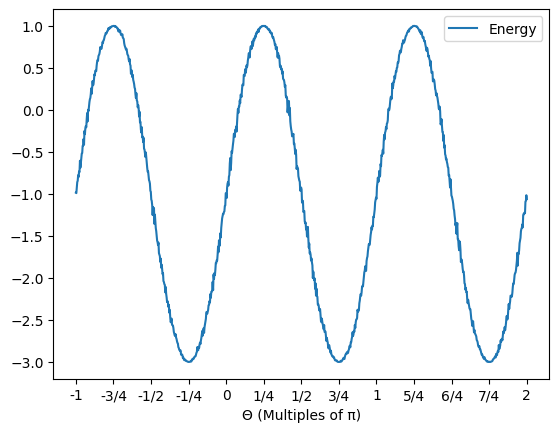

In [17]:
emulator = VQEEmulator(hamiltonian_fn="./anti-ferromagnetic-2q.h", ansatz_fn="./anti-ferromagnetic-2q.ansatz", backend=qiskit.BasicAer.get_backend("qasm_simulator"))

emulator.vqe(initial_state=qc_initial, method="cobyla")
emulator.plot_energy_landscape()